In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

from qiskit.circuit.library import QFT, CPhaseGate

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [2]:
depolarizing_prob = 0.1
dep_error = depolarizing_error(depolarizing_prob, 1)
dep_error_2q = depolarizing_error(depolarizing_prob, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

In [2]:
def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def mean(x: list, y: list):                 #bildet den Mittelwert unter den Shots einer Messung
    m = 0
    total = 0
    for i in range(len(x)):
        m += x[i]*y[i]
        total += y[i]
    m = m*(1/total)
    return m

def QPE(angle: float, precision: int) -> QuantumCircuit:
    qr = QuantumRegister(precision+1,"q")
    cbit = ClassicalRegister(precision,"c")
    qc = QuantumCircuit(qr,cbit)
    
    qc.x(precision)

    for i in range(precision):
        qc.h(i)
        for j in range(2**(i)):
            qc.cp(theta=2*np.pi*angle, control_qubit=i, target_qubit=precision)

    qft = QFT(num_qubits=precision, inverse=True).to_gate()
    hmm = [i for i in range(precision)]         #Liste der Qubits auf denen iQFT andgewendet wird
    qc.append(qft,qargs=hmm)
    return qc

In [5]:
def prec_over_error(angle: float, n: int, shots: int, steps:int ,times: int):
    soweit = 0.4
    error_1 = np.linspace(0,(4/3)*soweit,steps)
    error_2 = np.linspace(0,(16/15)*soweit,steps)
    x = np.linspace(0,1*soweit,steps)
    y_idk = np.zeros(len(x))
    for o in range(times):
        for j in range(len(error_1)):
            dep_error = depolarizing_error(error_1[j], 1)
            dep_error_2q = depolarizing_error(error_2[j], 2)

            noise_model = NoiseModel()
            noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
            noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

            qc = QPE(angle=angle, precision=n)

            for i in range(n):
                qc.measure(i,i)

            sim = AerSimulator()
            job = sim.run(qc.decompose(reps=n), noise_model=noise_model, shots=shots)
            result = job.result()
            counts = result.get_counts()    
                
            # x_old = list(counts.keys())
            # x_old = [convert(i) for i in x_old]
            # y_old = list(counts.values())
            # avg = mean(x_old,y_old)
            # y_idk[j] += np.abs(avg-angle)

            most = convert(max(counts, key=counts.get))
            y_idk[j] += np.abs(most-angle)

    y = [i/times for i in y_idk]
    fig, ax = plt.subplots(figsize=(13,7))
    ax = plt.plot(x,y, "x", label="Precision", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average
    plt.title("QPE: Dependence of Precision on the depolarizing errror with "+r"$\Theta$"+" = {}, {} ancillas and {} shots".format(angle, n, int(shots)))
    plt.yscale("log")
    plt.ylabel(r"$\vert \text{max}(\varphi) - \Theta \vert$")
    plt.xlabel("Depolarizing error")
    data = np.array((x,y))
    np.savetxt("QPE_error_threshhold.txt", data, delimiter=",")
    return plt.legend()
        

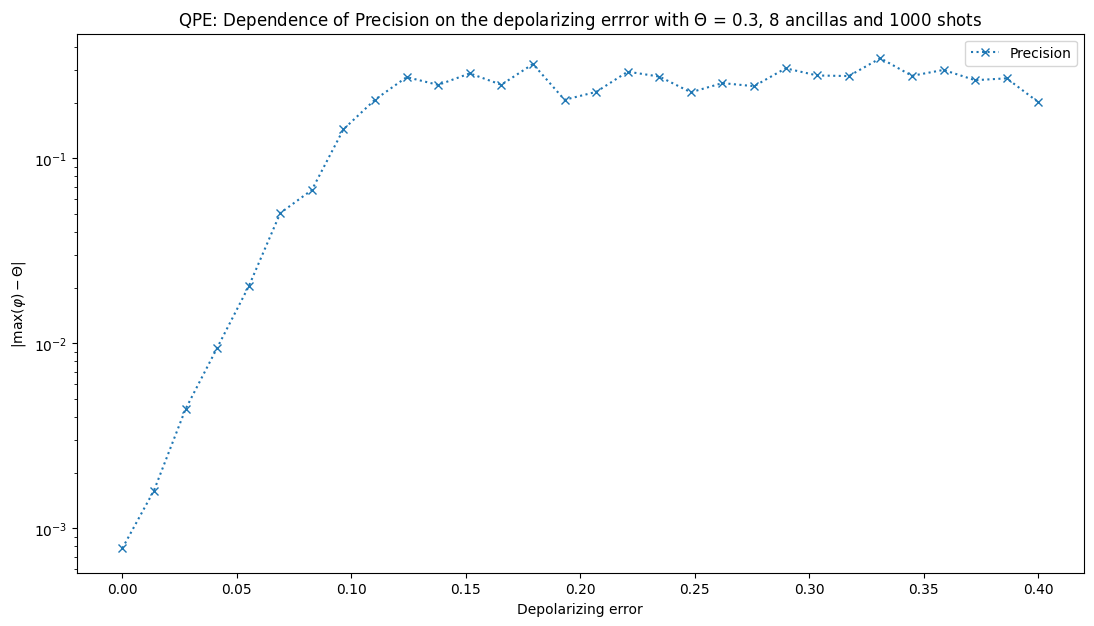

In [6]:
prec_over_error(0.3, 8, 1000, 30, 20)

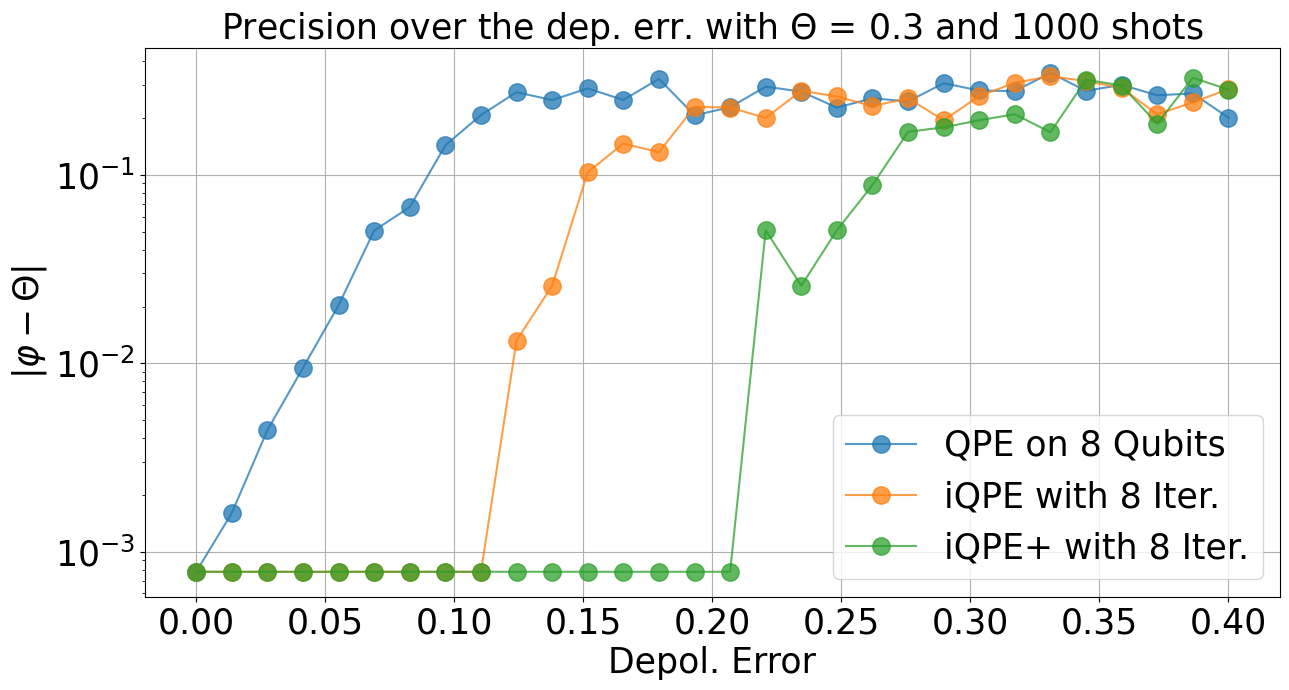

In [9]:
iQPE_plus = np.loadtxt("iQPE+_error_threshhold.txt", delimiter=",")
iQPE = np.loadtxt("iQPE_error_threshhold.txt", delimiter=",")
QPE = np.loadtxt("QPE_error_threshhold.txt", delimiter=",")

angle = 0.3
n = 8
shots = 1000

fig, ax = plt.subplots(figsize=(13,7))
ax = plt.plot(QPE[0,:],QPE[1,:], marker = ".", label="QPE on 8 Qubits", markersize = 25, alpha=0.75)
ax = plt.plot(iQPE[0,:],iQPE[1,:], marker = ".", label="iQPE with 8 Iter.", markersize = 25, alpha=0.75)
ax = plt.plot(iQPE_plus[0,:],iQPE_plus[1,:], marker = ".", label="iQPE+ with 8 Iter.", markersize = 25, alpha=0.75)
plt.title("Precision over the dep. err. with "+r"$\Theta$"+" = {} and {} shots".format(angle, int(shots)), fontsize = 25)
plt.yscale("log")
plt.ylabel(r"$\vert \varphi - \Theta \vert$",fontsize=25)
plt.xlabel("Depol. Error", fontsize=25)
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25)
#plt.rcParams.update({'font.size': 10})
plt.legend(fontsize=25, loc="lower right")
plt.grid()
plt.tight_layout()
#plt.savefig("Error_Threshhold.png", dpi = 300)

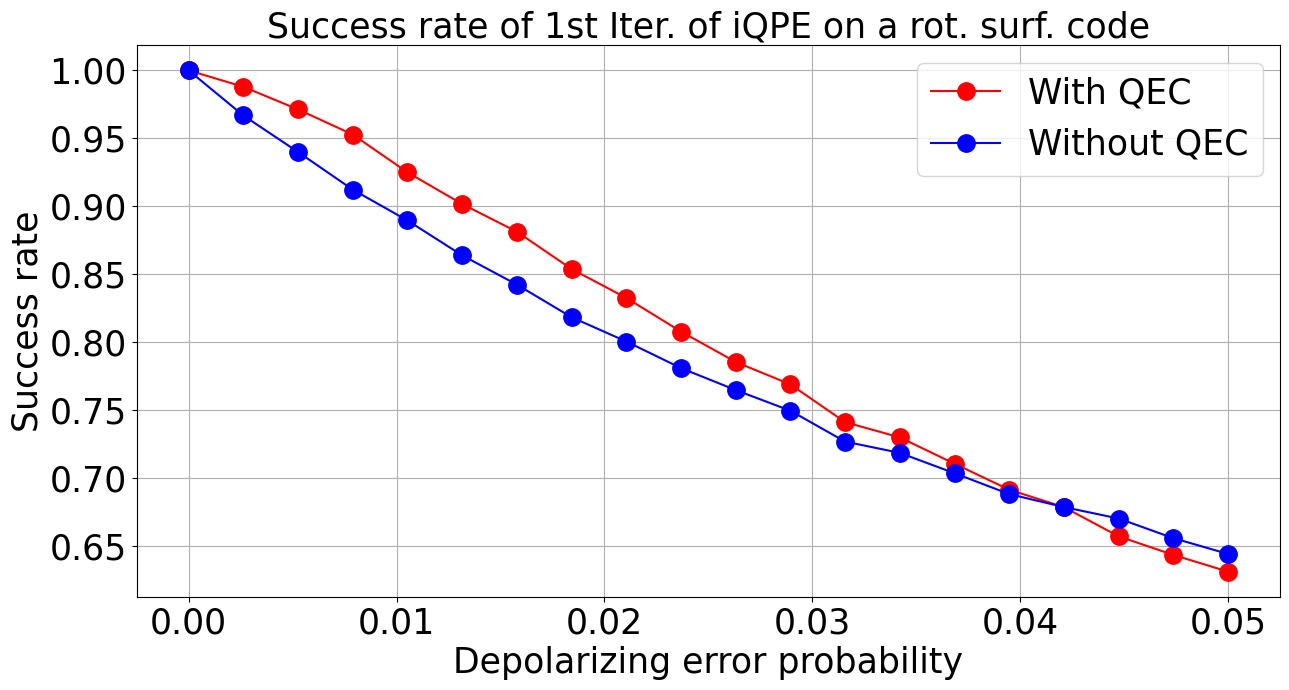

In [10]:
QEC = np.loadtxt("QEC.txt", delimiter=",")

x = QEC[0,:]
y = QEC[1,:]
y_no_QEC = QEC[2,:]

fig, ax = plt.subplots(figsize=(13,7))
ax.plot(x,y,label = "With QEC", color="red", marker = ".", markersize = 25)
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue", marker = ".", markersize = 25)
plt.title("Success rate of 1st Iter. of iQPE on a rot. surf. code", fontsize=25)
plt.xlabel("Depolarizing error probability", fontsize=25)
plt.ylabel("Success rate", fontsize=25)
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25)
plt.grid()
plt.legend(fontsize=25)
plt.tight_layout()

In [7]:
qr = QuantumRegister(3,"q")
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)

ancilla = qc.num_qubits - 1
magic = qc.num_qubits - 2

qc.h(magic)
qc.t(magic)

qc.cx(0,ancilla)
qc.cx(magic,ancilla)

qc.measure(ancilla,0)

with qc.if_test((0,1)):
    qc.s(0)

qc.h(magic)
qc.measure(magic,0)

with qc.if_test((0,1)):
    qc.z(0)

qc.measure(0,0)

qc.draw("latex_source")

/home/dustinseboldt/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/circuit_visualization.py:618: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  qcimg = _latex.QCircuitImage(


'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{q}_{0} :  } & \\lstick{{q}_{0} :  } & \\qw & \\ctrl{2} & \\qw & \\qw & \\qw & \\multigate{3}{\\mathrm{If_else}}_<<<{0} & \\qw & \\multigate{3}{\\mathrm{If_else}}_<<<{0} & \\meter & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{1} :  } & \\lstick{{q}_{1} :  } & \\gate{\\mathrm{H}} & \\qw & \\gate{\\mathrm{T}} & \\ctrl{1} & \\gate{\\mathrm{H}} & \\ghost{\\mathrm{If_else}} & \\meter & \\ghost{\\mathrm{If_else}} & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{2} :  } & \\lstick{{q}_{2} :  } & \\qw & \\targ & \\qw & \\targ & \\meter & \\ghost{\\mathrm{If_else}} & \\qw & \\ghost{\\mathrm{If_else}} & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{c} :  } & \\lstick{{c} :  } & \\cw & \\cw & \\cw & \\cw & \\cw \\ar @{<=} [-1,0] & \\cghost{\\mathrm{If_else}}_<<<{0} & \\cw \\ar @{<=} [-2,0] & \\cghost{\\mathrm{If_else}}_<